In [1]:
from categoriesDef import categories
cat = categories['high']
version = 'v0'
mB_var = 'mass_candB'

### Imports

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml
import time
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, DSetLoader
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [6]:
webFolder = os.environ['HOME']+'/public_html/BPH_RDst/kinematicCalibration_Bd_JpsiKst/'+version+'/'
if not os.path.isdir(webFolder):
    os.makedirs(webFolder)
    os.system('cp {v}../index.php {v}'.format(v=webFolder))

# Load MC

In [7]:
mcSample = DSetLoader('Bd_JpsiKst_General', candDir='ntuples_B2JpsiKst')
# dsetMC_loc = mcSample.skimmed_dir + '/{}_corr.root'.format(cat.name)
dsetMC_loc = mcSample.skimmed_dir + '/{}_bare.root'.format(cat.name)

dfMC = pd.DataFrame(rtnp.root2array(dsetMC_loc))

In [8]:
effMCgen = mcSample.effMCgen
brFileLoc = '/storage/af/group/rdst_analysis/BPhysics/data/forcedDecayChannelsFactors_v2.pickle'
decayBR = pickle.load(open(brFileLoc, 'rb'))['JPsiKst']
effCAND = mcSample.effCand['effCAND']
effSkim = mcSample.getSkimEff(cat.name+'_bare')

xsec_eff = 1
dxsec = 0
for f, df in [effMCgen['xsec'], effMCgen['effGEN'], decayBR, effCAND, effSkim]:
    xsec_eff *= f
    dxsec += np.square(df/f)
dxsec = xsec_eff * np.sqrt(dxsec)
print 'Expected evts/fb: {:.0f} +/- {:.0f}'.format(xsec_eff, dxsec)

Expected evts/fb: 5109 +/- 204


In [9]:
from pileup_utilities import pileupReweighter

puRew = pileupReweighter(dsetMC_loc, 'hAllNTrueIntMC', trg=cat.trg)
dfMC['wPU'] = puRew.getPileupWeights(dfMC['MC_nInteractions'])

loc = '/storage/af/group/rdst_analysis/BPhysics/data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v21count.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
        
nX = hTriggerSF.GetNbinsX()
ptWeight = [[] for k in range(nX+2)]

dfMC['trgSF'] = np.ones(dfMC.shape[0])
for i, (pt, eta, ip) in enumerate(dfMC[['trgMu_pt', 'trgMu_eta', 'trgMu_sigdxy']].values):
    ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
    iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
    iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
    dfMC.at[i, 'trgSF'] = hTriggerSF.GetBinContent(ix, iy, iz)
#     if np.abs(dfMC.at[i, 'trgSF'] - 1) > 0.1:
#         print (4*'{:.2f} ').format(pt, eta, ip, hTriggerSF.GetBinContent(ix, iy, iz))
    ptWeight[ix].append(hTriggerSF.GetBinContent(ix, iy, iz))
    
# Muon ID scale factor
loc = '/storage/af/group/rdst_analysis/BPhysics/data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root'
fMuonIDSF = rt.TFile.Open(loc, 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

dfMC['muonSF'] = np.ones(dfMC.shape[0])
for i, (ptp, etap, ptm, etam) in enumerate(dfMC[['MC_mup_pt', 'MC_mup_eta', 'MC_mum_pt', 'MC_mum_eta']].values):
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptp))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etap))
    wp = hMuonIDSF.GetBinContent(ix, iy)
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptm))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etam))
    wm = hMuonIDSF.GetBinContent(ix, iy)
    dfMC.at[i, 'muonSF'] = wp * wm
    
dfMC['w'] = dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF']

[pileup reweighting] wMax=79.0, wMin=0.0


In [10]:
dpt_rel = np.abs(dfMC['B_pt']/dfMC['MC_B_pt'] - 1)
deta = np.abs(dfMC['B_eta'] - dfMC['MC_B_eta'])
dphi = np.abs(dfMC['B_phi'] - dfMC['MC_B_phi'])
dphi = np.abs(dphi - 2*np.pi*(dphi > np.pi).astype(np.float))

safe = np.logical_and(np.logical_and(dpt_rel < 0.1, deta < 0.05), dphi < 0.05)
print 'MC purity: {:.1f}%'.format(100*np.sum(safe)/float(safe.shape[0]))

MC purity: 99.9%


In [11]:
print 'MC purity: {:.1f}%'.format(100*np.sum(dfMC['MC_idxMatch'] == 1)/float(dfMC['MC_idxMatch'].shape[0]))

MC purity: 73.2%


# Load data

In [12]:
dataDir = '/storage/af/group/rdst_analysis/BPhysics/data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2JpsiKst_210501*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
if not lumi_tot:
    expectedLumi = {'Low':6.4, 'Mid':20., 'High':26.} #fb^-1
    lumi_tot = expectedLumi[cat.name]
    print 'Total lumi (estimated): {:.1f} fb^-1'.format(lumi_tot)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_210501
HLT_Mu12_IP6_part2_v2 5.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_210501
HLT_Mu12_IP6_part1_v2 5.3
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_210501
HLT_Mu12_IP6_part4_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_210501
HLT_Mu12_IP6_part3_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_210501
HLT_Mu12_IP6_part0_v2 5.25
Total lumi: 26.41 fb^-1


In [13]:
dsetRD_loc = dataDir+'/skimmed/B2JpsiKst_210501_{}_corr.root'.format(cat.name)
dfRD = pd.DataFrame(rtnp.root2array(dsetRD_loc))

fRD_skimmed = rt.TFile.Open(dsetRD_loc, 'READ')
tRD_skimmed = fRD_skimmed.Get('Tevts')

N_sel_per_fb = tRD_skimmed.GetEntries()/lumi_tot
print 'Selected events per fb: {:.0f}'.format(N_sel_per_fb)

Selected events per fb: 4182


In [14]:
dfRD.columns

Index([u'index', u'trgMu_pt', u'trgMu_eta', u'trgMu_sigdxy', u'otherMu_pt',
       u'otherMu_eta', u'otherMu_phi', u'mum_pt', u'mum_eta', u'mum_phi',
       u'mum_dxy', u'mup_pt', u'mup_eta', u'mup_phi', u'mup_dxy', u'pval_mumu',
       u'mass_mumu', u'Jpsi_pt', u'Jpsi_eta', u'cosT_Jpsi_PV', u'K_pt',
       u'K_eta', u'K_phi', u'K_sigdxy_PV', u'pi_pt', u'pi_eta', u'pi_phi',
       u'pi_sigdxy_PV', u'pval_piK', u'mass_piK', u'mass_Kpi', u'mass_KK',
       u'Kst_pt', u'Kst_eta', u'Kst_phi', u'sigdxy_vtxKst_PV', u'pval_mumupiK',
       u'mass_mumupiK', u'mass_mumupiK_cJpsi', u'mass_mumupiK_cJpsi_cKst',
       u'B_pt', u'B_eta', u'B_phi', u'cos_B_PV', u'sigd_vtxB_PV',
       u'sigdxy_vtxB_PV', u'mass_mumuKpi', u'mass_mumuKpi_cJpsi',
       u'mass_mumuKpi_cJpsi_cKst', u'isAntiB', u'mass_candKst', u'mass_candB',
       u'cat_low', u'cat_mid', u'cat_high', u'N_vtx'],
      dtype='object')

# Compare data/MC

In [15]:
def makePlot(var, binning=None, axis_title=None, tag='', saveFig=''):
    hRD = create_TH1D(dfRD[var], name='hRD',
                axis_title=axis_title,
                binning=binning,
                scale_histo='norm'
               )
    hRD.SetMarkerStyle(15)

    hMC = create_TH1D(dfMC[var], name='hMC',
                      binning=hRD.binning,
                      weights=dfMC['w'],
                      scale_histo='norm' 
                     )
    hMC.SetLineColor(rt.kRed)

    leg = rt.TLegend(0.8, 0.7, 0.95,0.8)
    leg.SetBorderSize(0)
    leg.AddEntry(hRD, 'Data', 'lep')
    leg.AddEntry(hMC, 'MC', 'le')

    CMS_lumi.integrated_lumi = lumi_tot
    m = SetMaxToMaxHist([hRD, hMC])
    c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
    leg.Draw()
    c.leg = leg
    catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
    if saveFig:
        c.SaveAs(webFolder+saveFig)

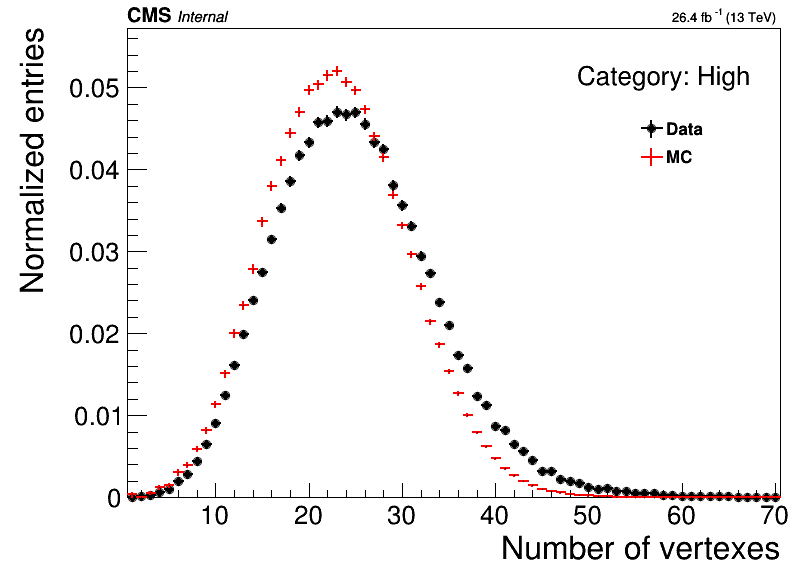

In [16]:
makePlot('N_vtx', binning=[70, 0.5, 70.5], 
         axis_title=['Number of vertexes', 'Normalized entries'], saveFig='reconstructedVertexes.png')

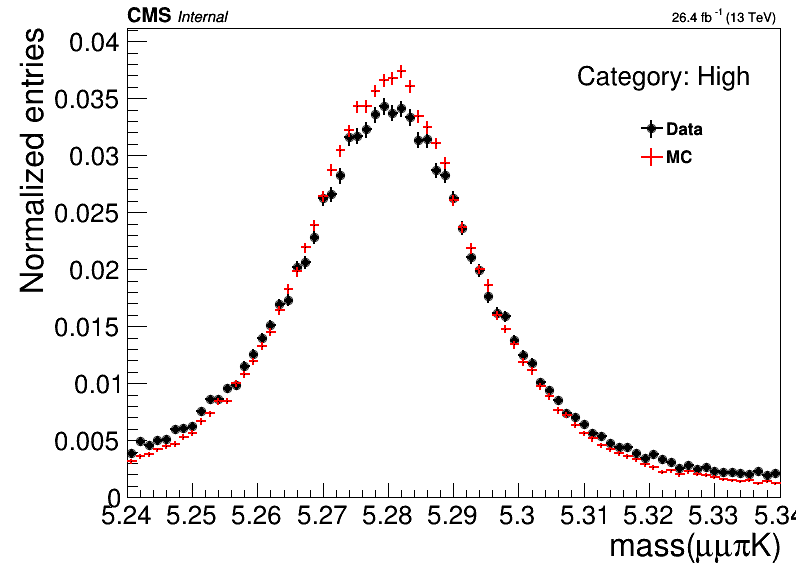

In [17]:
makePlot(mB_var, binning=[75, 5.24, 5.34], 
         axis_title=['mass(#mu#mu#piK)', 'Normalized entries'], saveFig='mass_mumupiK_precal.png')

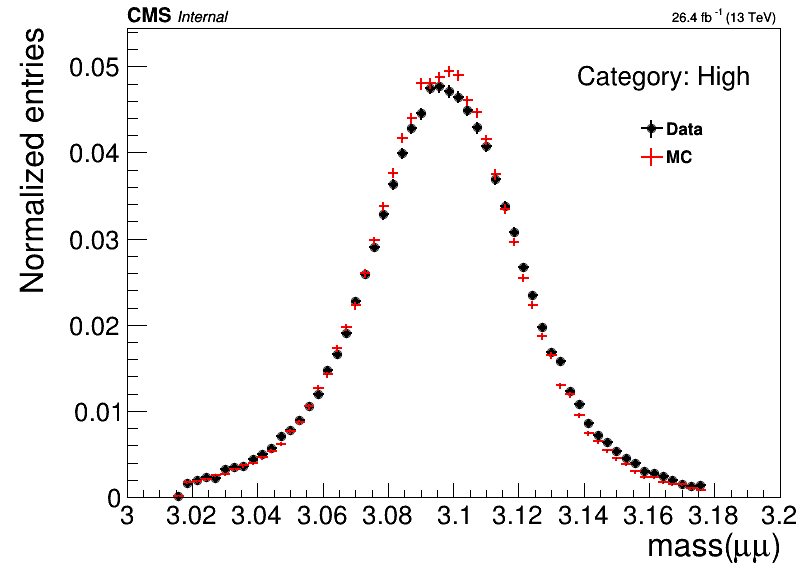

In [18]:
makePlot('mass_mumu', binning=[70, 3.0, 3.2], 
         axis_title=['mass(#mu#mu)', 'Normalized entries'], saveFig='mass_mumu_precal.png')

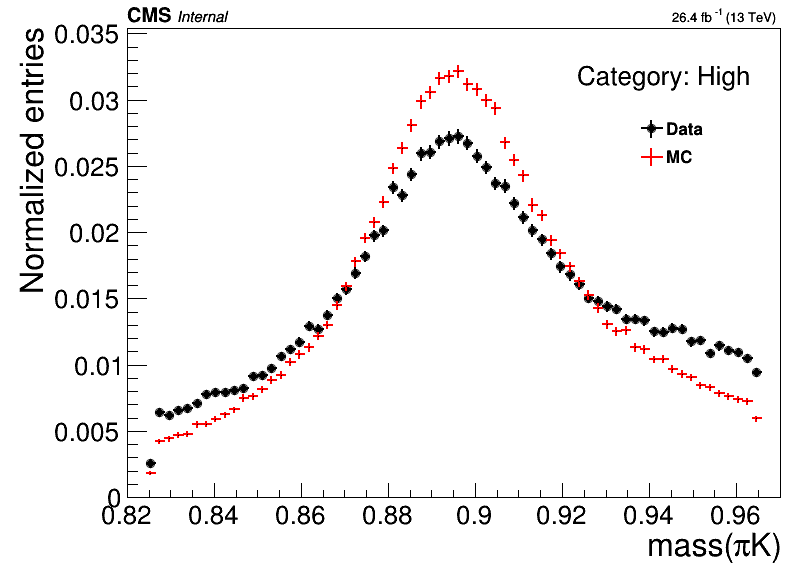

In [19]:
makePlot('mass_candKst', binning=[70, 0.82, 0.97], 
         axis_title=['mass(#piK)', 'Normalized entries'], saveFig='mass_Kst_precal.png')

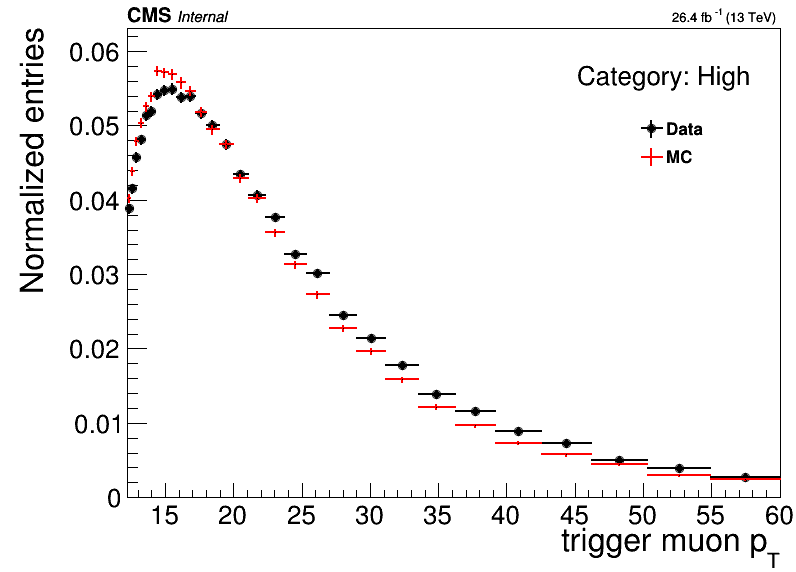

In [20]:
b = {'Low': array('d', list(np.arange(7, 9.4, 0.1)) + [9.4]),
     'Mid': array('d', list(np.arange(9, 12.2, 0.1)) +[12.2]),
     'High': array('d', list(10+np.logspace(np.log10(12.2-10), np.log10(50), 30)))
    }

makePlot('trgMu_pt', binning=b[cat.name], 
         axis_title=['trigger muon p_{T}', 'Normalized entries'], saveFig='trgMu_pt_precal.png')

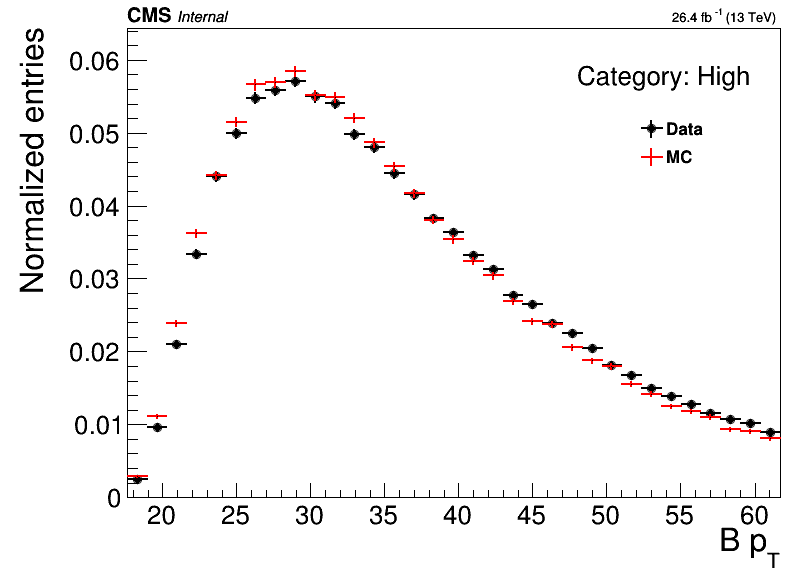

In [21]:
for n in ['otherMu', 'K', 'pi', 'Jpsi', 'Kst', 'B']:
    makePlot(n+'_pt', binning=3*[None], 
             axis_title=[n+' p_{T}', 'Normalized entries'], saveFig=n+'_pt_precal.png')

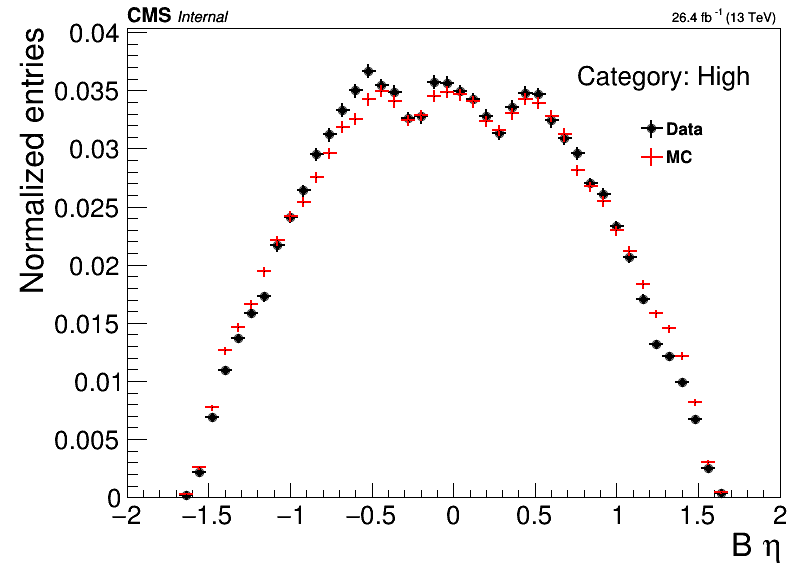

In [22]:
for n in ['trgMu', 'otherMu', 'K', 'pi', 'Jpsi', 'Kst', 'B']:
    makePlot(n+'_eta', binning=[50, -2, 2], 
             axis_title=[n+' #eta', 'Normalized entries'], saveFig=n+'_eta_precal.png')

# Clean sets

In [23]:
cuts = [
#     ['B_eta', [-1, 1]],
    [mB_var, [5.24, 5.34]],
]

for i, d in enumerate([dfMC, dfRD]):
    sel = np.ones_like(d['mum_pt']).astype(np.bool)
    for v, [ll, ul] in cuts:
        sel = np.logical_and(sel, np.logical_and(d[v] > ll, d[v] < ul))
    if i == 0:
        dfMCc = d[sel]
    else:
        dfRDc = d[sel]

# Eta Calibration

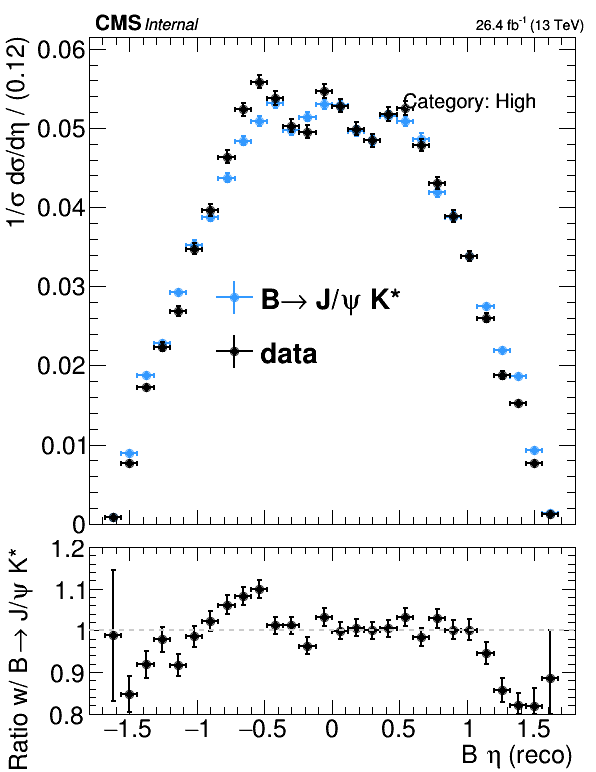

In [24]:
b=[30,-1.8,1.8]
binWdith = (b[2] - b[1])/float(b[0])
hRD = create_TH1D(dfRDc['B_eta'], name='hRD',
                  title='data',
                  axis_title=['B #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMC = create_TH1D(dfMCc['B_eta'], name='hMC', 
                  weights=dfMCc['w'],
                  axis_title=['B #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  title = 'B#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  h2clone=hRD, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hMC, hRD], ratio_bounds=[0.8, 1.2], draw_opt='E1')

CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
# c.pad2.SetLogy()
c.leg.SetY1(0.3)
c.leg.SetY2(0.5)
c.leg.SetX1(0.35)
c.leg.SetX2(0.7)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.8, 'Category: {}'.format(cat.name))
c.SaveAs(webFolder+'B_eta_' + cat.name + '_precal.png')

In [25]:
y = []
yerr = []
x = []
hAux = hRD.Clone('hAux')
hAux.Divide(hMC)
for i in range(1, hRD.GetNbinsX()+1):
    if np.abs(hAux.GetBinContent(i))<1e-3:
        continue
    x.append(hAux.GetBinCenter(i))
    y.append(hAux.GetBinContent(i))
    yerr.append(hAux.GetBinError(i))

In [26]:
print y

[0.9876626643605778, 0.8474135915395812, 0.917921119165377, 0.9783193973964415, 0.9163158720785343, 0.9850903040570642, 1.0230971367972623, 1.0611538481948466, 1.082032936236874, 1.098735951105988, 1.0122728341341258, 1.0122381615227414, 0.9633286602929984, 1.0316918850447685, 0.9986564752529905, 1.006125701699737, 0.9994502744772498, 1.0051882480661811, 1.0317683981174268, 0.9839682089986143, 1.0282564420939164, 1.0014835446767887, 1.0016562526321287, 0.9461943115988126, 0.8567213040640518, 0.8202682737551652, 0.818067678960477, 0.8848834007167671]


In [27]:
deg = 5
beta, covBeta = np.polyfit(x, y, deg=deg, full=False, w=1./np.array(yerr), cov='unscaled')
print beta
print np.sqrt(np.diag(covBeta))

[-0.01241886 -0.06071735  0.03343134  0.04573835 -0.037599    1.01205135]
[0.02373334 0.01916755 0.06085286 0.03742546 0.0342394  0.01239084]


In [28]:
eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])

Beta:  -1.24e-02, -6.07e-02, 3.34e-02, 4.57e-02, -3.76e-02, 1.01e+00
Error: 2.37e-02, 1.92e-02, 6.09e-02, 3.74e-02, 3.42e-02, 1.24e-02


eigSigma: 7.22e-02
eigVect: 0.31, -0.01, -0.84, 0.01, 0.44, -0.00
Variation: 2.27e-02, -5.95e-04, -6.07e-02, 9.42e-04, 3.18e-02, -1.69e-04


eigSigma: 4.26e-02
eigVect: -0.00, 0.43, -0.01, -0.88, 0.01, 0.21
Variation: -3.37e-05, 1.84e-02, -4.97e-04, -3.74e-02, 5.72e-04, 9.00e-03


eigSigma: 1.47e-02
eigVect: 0.44, -0.01, -0.28, -0.01, -0.85, 0.02
Variation: 6.49e-03, -1.50e-04, -4.16e-03, -1.62e-04, -1.26e-02, 2.26e-04


eigSigma: 3.27e-03
eigVect: -0.84, -0.07, -0.46, -0.04, -0.28, -0.03
Variation: -2.74e-03, -2.43e-04, -1.50e-03, -1.33e-04, -9.16e-04, -9.23e-05


eigSigma: 4.26e-03
eigVect: 0.07, -0.77, 0.04, -0.48, 0.03, -0.42
Variation: 3.04e-04, -3.28e-03, 1.86e-04, -2.04e-03, 1.29e-04, -1.77e-03


eigSigma: 9.41e-03
eigVect: 0.00, -0.47, 0.01, -0.02, 0.02, 0.88
Variation: 9.14e-07, -4.39e-03, 1.07e-04, -1.50e-04, 1.69e-04, 8.32e-03


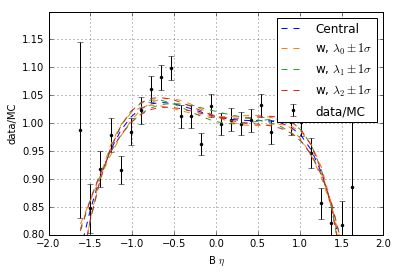

In [29]:
plt.errorbar(x, y, yerr=yerr, fmt='k.', label='data/MC')
plt.plot(x, np.polyval(beta, x), '--', label='Central')

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(len(betaVar)):
    if i > 2:
        break
    yP = np.polyval(beta+betaVar[i], x)
    yM = np.polyval(beta-betaVar[i], x)
    plt.plot(x, yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
    plt.plot(x, yM, '--', color=colors[i])

plt.grid()
plt.ylim(0.8, 1.2)
plt.ylabel('data/MC')
plt.xlabel(r'B $\eta$')
plt.legend(loc='best', numpoints=1)
plt.savefig(webFolder+'etaRatio_' + cat.name + '.png', bbox_inches='tight')

In [30]:
dOut = {
    'beta': beta,
    'betaVar' : betaVar
}

pickle.dump(dOut, open('/storage/af/group/rdst_analysis/BPhysics/data/calibration/kinematicCalibration_Bd/eta_polyCoeff_{}_{}.pkl'.format(cat.name, version), 'wb'))

In [31]:
from pT_calibration_reader import pTCalReader as calibrationReader
cal_eta = calibrationReader(
    calibration_file='/storage/af/group/rdst_analysis/BPhysics/data/calibration/kinematicCalibration_Bd/eta_polyCoeff_{}_{}.pkl'.format(cat.name, version)
)
dfMCc['wEta'] = cal_eta.getWeights(dfMCc['B_eta'])

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


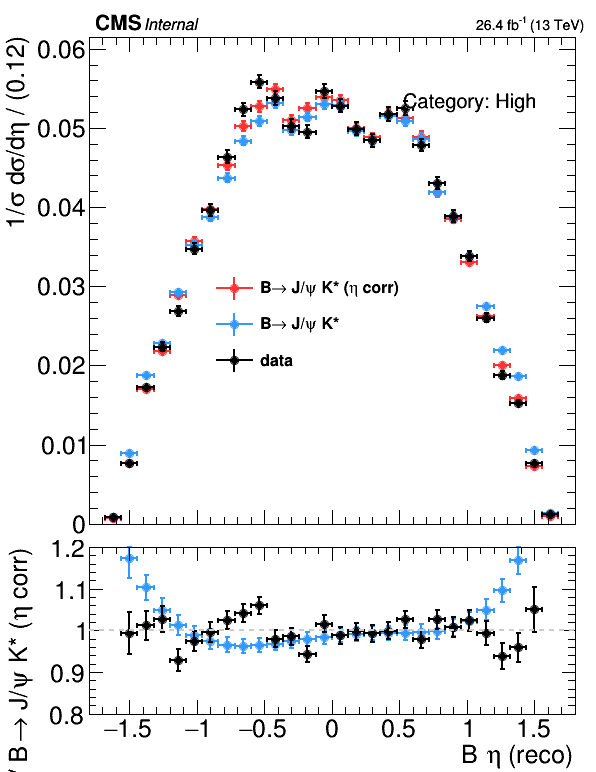

In [32]:
b=[30,-1.8,1.8]
binWdith = (b[2] - b[1])/float(b[0])
hRD = create_TH1D(dfRDc['B_eta'], name='hRD',
                  title='data',
                  axis_title=['B #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMC1 = create_TH1D(dfMCc['B_eta'], name='hMC', 
                  weights=dfMCc['w'],
                  axis_title=['B #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  title = 'B#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  h2clone=hRD, opt='overflow+underflow')

hMC2 = create_TH1D(dfMCc['B_eta'], name='hMC', 
                  weights=dfMCc['w']*dfMCc['wEta'],
                  axis_title=['B #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  title = 'B#rightarrow J/#psi K* (#eta corr)',
                  scale_histo='norm', color=1,
                  h2clone=hRD, opt='overflow+underflow')


CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hMC2, hMC1, hRD], ratio_bounds=[0.8, 1.2], draw_opt='E1')

CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
# c.pad2.SetLogy()
c.leg.SetY1(0.3)
c.leg.SetY2(0.5)
c.leg.SetX1(0.35)
c.leg.SetX2(0.7)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.8, 'Category: {}'.format(cat.name))
c.SaveAs(webFolder+'B_eta_' + cat.name + '_etaOnlycal.png')

# pT Calibration

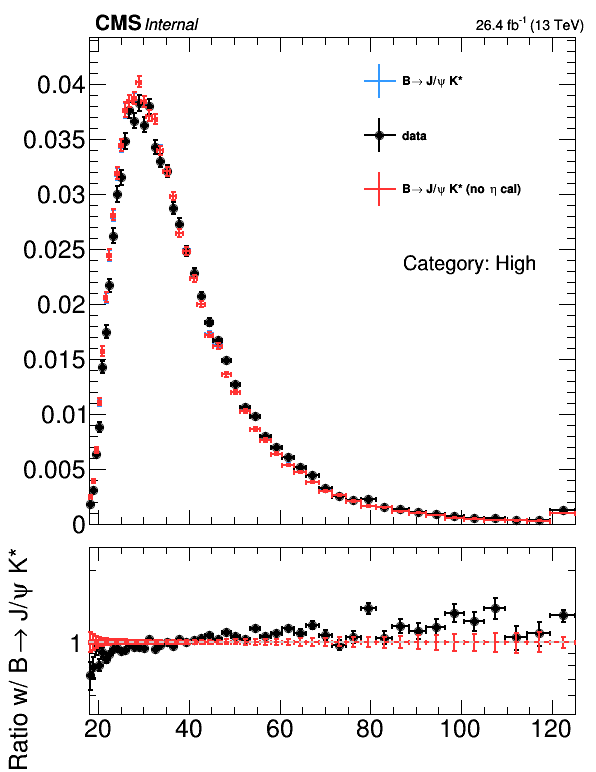

In [33]:
lowOff = 5
midOff = 10
highOff = 5
b = {'Low': array('d', list( lowOff+np.logspace(np.log10(12-lowOff), np.log10(90-lowOff), 40) )),
     'Mid': array('d', list( midOff+np.logspace(np.log10(14-midOff), np.log10(100-midOff), 45) )),
     'High': array('d', list( highOff+np.logspace(np.log10(18-highOff), np.log10(125-highOff), 50) )),
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH1D(dfRDc['B_pt'], name='hRD',
                  title='data',
                  axis_title=['B p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T}'],
                  binning=b[cat.name],
                  scale_histo='norm',
                  widthNorm=True,
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMCc['B_pt'], name='hMCb',
                  title = 'B#rightarrow J/#psi K* (no #eta cal)',
                  weights=dfMCc['w'],
                  scale_histo='norm', color=1,
                  widthNorm=True,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMCc['B_pt'], name='hMC', 
                  weights=dfMCc['w']*dfMCc['wEta'],
                  title = 'B#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  widthNorm=True,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot([hMC, hRD, hMCb], ratio_bounds=[0.5, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.5, 10], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
cr.pad2.SetLogy()
cr.leg.SetY2(0.9)
cr.leg.SetY1(0.6)
cr.leg.SetX1(0.6)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))

cr.SaveAs(webFolder+'BpT_preCal_' + cat.name + '.png')

In [34]:
y = []
yerr = []
x = []
hAux = hRD.Clone('hAux')
hAux.Divide(hMC)
for i in range(1, hRD.GetNbinsX()+1):
#     if np.abs(hAux.GetBinCenter(i))>1:
#         continue
    x.append(hAux.GetBinCenter(i))
    y.append(hAux.GetBinContent(i))
    yerr.append(hAux.GetBinError(i))
yerr = np.array(yerr)


Chi2/dof = 73.54/45 (0.5%)


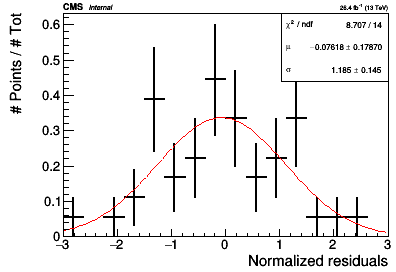

In [35]:
deg = 3
# beta, covBeta = np.polyfit(dic['pt'], dic['w'], deg=deg, full=False, w=1./dic['w_err'], cov=True)
beta, covBeta = np.polyfit(x, y, deg=deg, full=False, w=1./yerr, cov='unscaled')

res = (y - np.polyval(beta, x))/yerr

chi2stat = np.sum(np.square(res))
dof = res.shape[0]-deg-1
pval = 1 - sps.chi2.cdf(chi2stat, df=dof)
print '\nChi2/dof = {:.2f}/{:.0f} ({:.1f}%)'.format(chi2stat, dof, 100*pval)

h = create_TH1D(res, binning=[16, -3,3],
                axis_title=['Normalized residuals', '# Points / # Tot'],
                scale_histo='norm'
               )
h.Scale(1./h.GetBinWidth(2))

fGaus = rt.TF1('fFit', 'exp(-(x-[0])*(x-[0])/(2*[1]*[1]))/({:.4f}*[1])'.format(np.sqrt(2*np.pi)), -5, 5)
fGaus.SetParameters(0,1)
fGaus.SetParNames('#mu','#sigma')
h.Fit(fGaus, 'QWL')
cResiduals = drawOnCMSCanvas(CMS_lumi, [h], ['E'], tag='residuals', size=[400,300])
textPave = h.FindObject('stats')
textPave.SetY1NDC(0.7)
textPave.SetY2NDC(0.95)

In [36]:
eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])
    
dOut = {
    'beta': beta,
    'betaVar' : betaVar
}

pickle.dump(dOut, open('/storage/af/group/rdst_analysis/BPhysics/data/calibration/kinematicCalibration_Bd/pt_polyCoeff_{}_{}.pkl'.format(cat.name, version), 'wb'))

Beta:  8.77e-07, -2.02e-04, 1.69e-02, 6.09e-01
Error: 4.56e-07, 8.62e-05, 4.79e-03, 7.92e-02


eigSigma: 7.94e-02
eigVect: 0.00, -0.00, 0.06, -1.00
Variation: 4.10e-07, -8.16e-05, 4.72e-03, -7.92e-02


eigSigma: 8.27e-04
eigVect: -0.00, 0.03, -1.00, -0.06
Variation: -1.81e-07, 2.67e-05, -8.25e-04, -4.92e-05


eigSigma: 2.97e-08
eigVect: -1.00, -0.01, -0.00, -0.00
Variation: -2.97e-08, -3.34e-10, -4.31e-12, -6.61e-14


eigSigma: 6.93e-06
eigVect: -0.01, 1.00, 0.03, 0.00
Variation: -7.81e-08, 6.93e-06, 2.24e-07, 6.20e-09


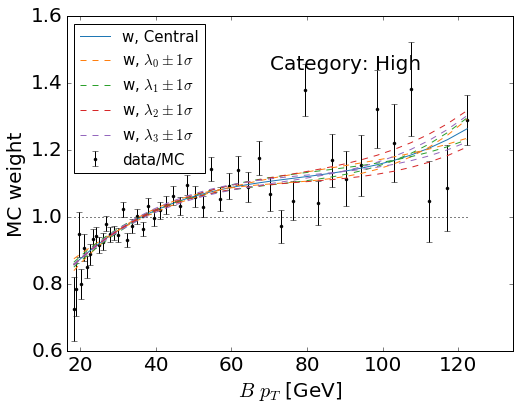

In [37]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr, fmt='.k', label='data/MC')

plt.plot(x, np.polyval(beta, x), '-', color='#1f77b4', label='w, Central')

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(len(betaVar)):
    yP = np.polyval(beta+betaVar[i], x)
    yM = np.polyval(beta-betaVar[i], x)
    plt.plot(x, yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
    plt.plot(x, yM, '--', color=colors[i])
    
plt.plot(x , [1]*len(x), ':k')
plt.legend(loc='best', numpoints=1, fontsize=15)
plt.xlabel('$B\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(x), 1.1*np.max(x))
plt.text(0.9*np.max(x) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
plt.savefig(webFolder+'ptRatio_' + cat.name + '.png')

In [38]:
cal_pT = calibrationReader(
    calibration_file='/storage/af/group/rdst_analysis/BPhysics/data/calibration/kinematicCalibration_Bd/pt_polyCoeff_{}_{}.pkl'.format(cat.name, version)
)
dfMCc['wPt'] = cal_pT.getWeights(dfMCc['MC_B_pt'])

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [39]:
h_var = {}
h_var['C'] = create_TH1D(dfMCc['B_pt'], name='h_var_C', binning=hRD.binning, opt='underflow+overflow',
                         weights=dfMCc['w']*dfMCc['wEta']*dfMCc['wPt'])
norm = float(h_var['C'].Integral())
h_var['C'].Scale(1./norm, 'width')

mVar = np.array(betaVar)
nIter = 1000
binContent = np.zeros((nIter, hRD.GetNbinsX()))
pb = ProgressBar(nIter)
for itx in range(nIter):
    pb.show(itx)
    p = beta + np.sum(np.random.normal(size=(beta.shape[0],1))*mVar, axis=0)
    
    wPt = np.polyval(p, dfMCc['MC_B_pt'])
    hAux = create_TH1D(dfMCc['B_pt'], name='hAux', binning=hRD.binning, opt='underflow+overflow', 
                       weights=dfMCc['w']*dfMCc['wEta']*wPt)
    hAux.Scale(1./norm, 'width')
    
    for i in range(1, binContent.shape[1]+1):
        binContent[itx, i-1] = hAux.GetBinContent(i)

for n, var in {'Down':-1, 'Up':1}.iteritems():
    h_var[n] = h_var['C'].Clone('h_var_'+n)
    content = np.percentile(binContent, q=100*sps.norm.cdf(var), axis=0)
    for i in range(1, content.shape[0]+1):
        h_var[n].SetBinContent(i, content[i-1]) 

[####################]  100% - Tot. time: 15.4 s


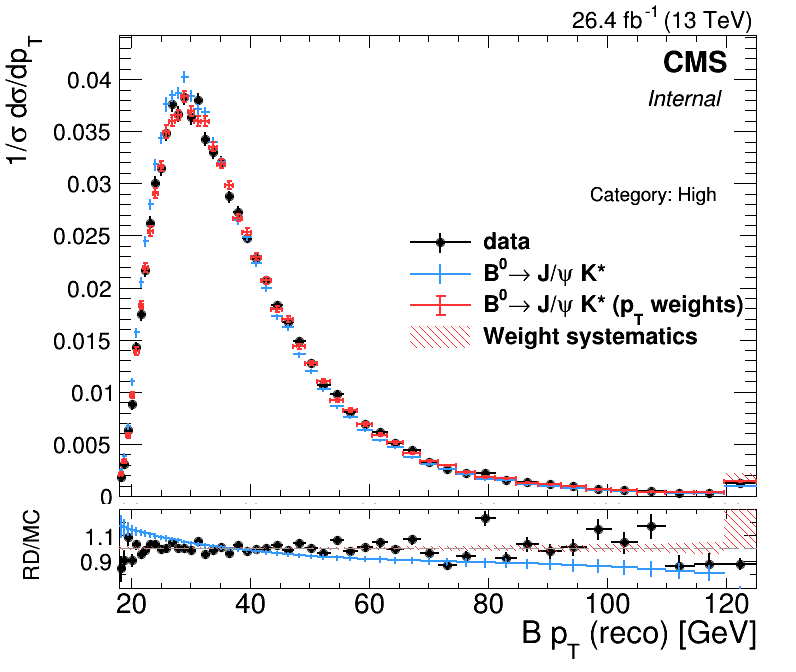

In [40]:
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
h_dr = hRD.Clone('h_aux_dataratio')
h_mr = hMC.Clone('h_aux_MCratio')
g_up = rt.TGraph()
g_up.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
g_down = rt.TGraph()
g_down.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    c = h_dr.GetBinContent(ib)
    e = h_dr.GetBinError(ib)
    h_dr.SetBinContent(ib, c/y)
    h_dr.SetBinError(ib, e/y)
    c = h_mr.GetBinContent(ib)
    e = h_mr.GetBinError(ib)
    h_mr.SetBinContent(ib, c/y)
    h_mr.SetBinError(ib, e/y)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
    
    x_low = h_dr.GetBinCenter(ib) - 0.5*h_dr.GetBinWidth(ib)
    x_up = h_dr.GetBinCenter(ib) + 0.5*h_dr.GetBinWidth(ib)
    g_up.SetPoint(2*ib-1, x_low, (y+dy_up)/y)
    g_up.SetPoint(2*ib, x_up, (y+dy_up)/y)
    g_down.SetPoint(2*ib-1, x_low, (y-dy_low)/y)
    g_down.SetPoint(2*ib, x_up, (y-dy_low)/y)
g_up.SetPoint(2*ib+1, x_up, 1)
g_down.SetPoint(2*ib+1, x_up, 1)
gr_stat.SetLineColor(rt.kRed-4)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kRed-4)
gr_sys.SetFillColor(rt.kRed-4)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.5, 0.3, 0.93,0.55)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, 'B^{0}#rightarrow J/#psi K*', 'le')
leg.AddEntry(gr_stat, 'B^{0}#rightarrow J/#psi K* (p_{T} weights)', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

SetMaxToMaxHist([hRD, hMC])
c = rt.TCanvas('c', 'c', 50, 50, 800, 700)
c.SetTickx(0)
c.SetTicky(0)

pad = rt.TPad('pmain', 'pmain', 0, 0.25, 1, 1)
pad.SetBottomMargin(0.015)
pad.SetTopMargin(0.07)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw()
pad.cd()
hRD.Draw()
hMC.Draw('same')
gr_stat.Draw('p')
gr_sys.Draw('2')
leg.Draw()
catText.DrawLatexNDC(0.9, 0.6, 'Category: {}'.format(cat.name))
CMS_lumi.extraText = '     Internal'
CMS_lumi.integrated_lumi = lumi_tot
CMS_lumi.CMS_lumi(pad, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

c.cd()
pad = rt.TPad('ppull', 'ppull', 0, 0, 1, 0.25)
pad.SetBottomMargin(0.5)
pad.SetTopMargin(0.03)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw('same')
pad.cd()
h_dr.GetYaxis().SetTitle('RD/MC')
t = 0.1
h_dr.GetYaxis().SetRangeUser(1 - 3*t, 1 + 3*t)
h_dr.GetYaxis().SetTitleOffset(0.5)
h_dr.GetYaxis().SetTitleSize(0.14)
h_dr.GetYaxis().SetLabelSize(0.15)
h_dr.GetYaxis().SetNdivisions(-203)
h_dr.GetXaxis().SetTitleOffset(0.95)
h_dr.GetXaxis().SetTitleSize(0.2)
h_dr.GetXaxis().SetLabelSize(0.18)
h_dr.GetXaxis().SetTickSize(0.07)
h_dr.Draw('E0')
h_mr.Draw('sameE0')
g_up.SetFillColor(rt.kRed-4)
g_up.SetFillStyle(3005)
g_up.Draw('F')
g_down.SetFillColor(rt.kRed-4)
g_down.SetFillStyle(3005)
g_down.Draw('F')
gh_dr = rt.TGraphErrors()
for i in range(1, h_dr.GetNbinsX()+1):
    gh_dr.SetPoint(i-1, h_dr.GetBinCenter(i), h_dr.GetBinContent(i))
    gh_dr.SetPointError(i-1, h_dr.GetBinError(i))
gh_dr.SetLineColor(h_dr.GetLineColor())
gh_dr.Draw('P0')
ax = h_dr.GetYaxis()
ax.ChangeLabel(1, -1, -1, -1, -1, -1, ' ')
ax.ChangeLabel(4, -1, -1, -1, -1, -1, ' ')

l = rt.TLine()
l.SetLineColor(rt.kGray+1)
l.SetLineWidth(1)
l.SetLineStyle(9)
x_low = h_dr.GetBinCenter(1)-0.5*h_dr.GetBinWidth(1)
x_high = h_dr.GetBinCenter(h_dr.GetNbinsX())+0.5*h_dr.GetBinWidth(h_dr.GetNbinsX())
l.DrawLine(x_low, 1, x_high, 1)


c.Draw()

c.SaveAs(webFolder+'closure_' + cat.name +'.png')

In [41]:
print 'DONE'

DONE
